# 📚 Content-Based Recommender-System für Bücher

Dieses Notebook implementiert ein content-basiertes Empfehlungssystem auf Basis von Buchdaten und Nutzerrezensionen. Dabei werden eigene Stopwords berücksichtigt und Rezensionstexte in die Merkmalsvektoren einbezogen.

In [2]:
# --- Importe ---
import pandas as pd
import numpy as np
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import random

## 🔍 Datenüberblick vor der Bereinigung

In [5]:
# Spalten festlegen
ratings_cols = ["Id", "Title", "User_id", "review/score", "review/summary", "review/text"]
data_cols = ["Title", "description", "authors", "categories"]

# Daten einlesen
ratings = pd.read_csv("Books_rating.csv", usecols=ratings_cols)
books = pd.read_csv("books_data.csv", usecols=data_cols)

# Vorschau
print("📐 Ratings:", ratings.shape)
print("📘 Books:", books.shape)
display(ratings.head())
display(books.head())

📐 Ratings: (3000000, 6)
📘 Books: (212404, 4)


,Id,Title,User_id,review/score,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,4.0,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,5.0,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,5.0,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,4.0,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,4.0,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


,Title,description,authors,categories
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],['Comics & Graphic Novels']
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography']
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],['Religion']
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],['Fiction']
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN


## 🧹 Datenbereinigung
Wir entfernen unvollständige oder doppelte Einträge und füllen fehlende Werte.

In [6]:
# Entferne unvollständige Bewertungen
ratings = ratings.dropna(subset=["User_id", "Title", "review/text"])
ratings["review/summary"] = ratings["review/summary"].fillna("")

# Entferne doppelte Bewertungen
ratings = ratings.drop_duplicates(subset=["User_id", "Title", "review/text"])

# Entferne doppelte Bücher
books = books.drop_duplicates()

# Filtere nur Bücher mit Bewertungen
books = books[books["Title"].isin(ratings["Title"])]

# Fehlende Textspalten füllen
for col in ["description", "authors", "categories"]:
    books[col] = books[col].fillna("")

## ✅ Datenüberblick nach der Bereinigung

In [4]:
print("📐 Ratings (bereinigt):", ratings.shape)
print("📘 Books (bereinigt):", books.shape)
display(ratings.head())
display(books.head())

📐 Ratings (bereinigt): (2132260, 6)
📘 Books (bereinigt): (206711, 4)


,Id,Title,User_id,review/score,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,4.0,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,5.0,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,5.0,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,4.0,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,4.0,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


,Title,description,authors,categories
0,Its Only Art If Its Well Hung!,,['Julie Strain'],['Comics & Graphic Novels']
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography']
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],['Religion']
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],['Fiction']
4,"Nation Dance: Religion, Identity and Cultural ...",,['Edward Long'],


## 🚫 Eigene Stopwords definieren

In [7]:
custom_stopwords = [
    # Ursprüngliche
    'book', 'read', 'one', 'like', 'author', 'story', 'would',
    'really', 'also', 'could', 'even', 'time', 'characters', 'well',

    # Neue Ergänzungen (nur nichtssagende oder wertende Begriffe)
    'just', 'great', 'good', 'best', 'new', 'written', 'books'
]


stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stopwords))

## 🧠 Feature-Vektoren erstellen (inkl. Rezensionstexte)

In [8]:
# Rezensionstexte pro Buch aggregieren
review_texts = ratings.groupby("Title")["review/text"].apply(lambda x: " ".join(x)).reset_index()
review_summaries = ratings.groupby("Title")["review/summary"].apply(lambda x: " ".join(x)).reset_index()

# Zusammenführen mit Buchdaten
books = books.merge(review_texts, on="Title", how="left").merge(review_summaries, on="Title", how="left")

# Fehlende Rezensionen auffüllen
books["review/text"] = books["review/text"].fillna("")
books["review/summary"] = books["review/summary"].fillna("")

# Feature-Kombination mit Gewichtung und Begrenzung
books["combined_features"] = (
    (books["Title"] + " ") * 2 +
    books["authors"] + " " +
    books["categories"] + " " +
    books["description"] + " " +
    books["review/text"].str[:1000]  # max. 1000 Zeichen aus Reviews
).str.lower().str.replace(r'[^a-z0-9 ]', '', regex=True)


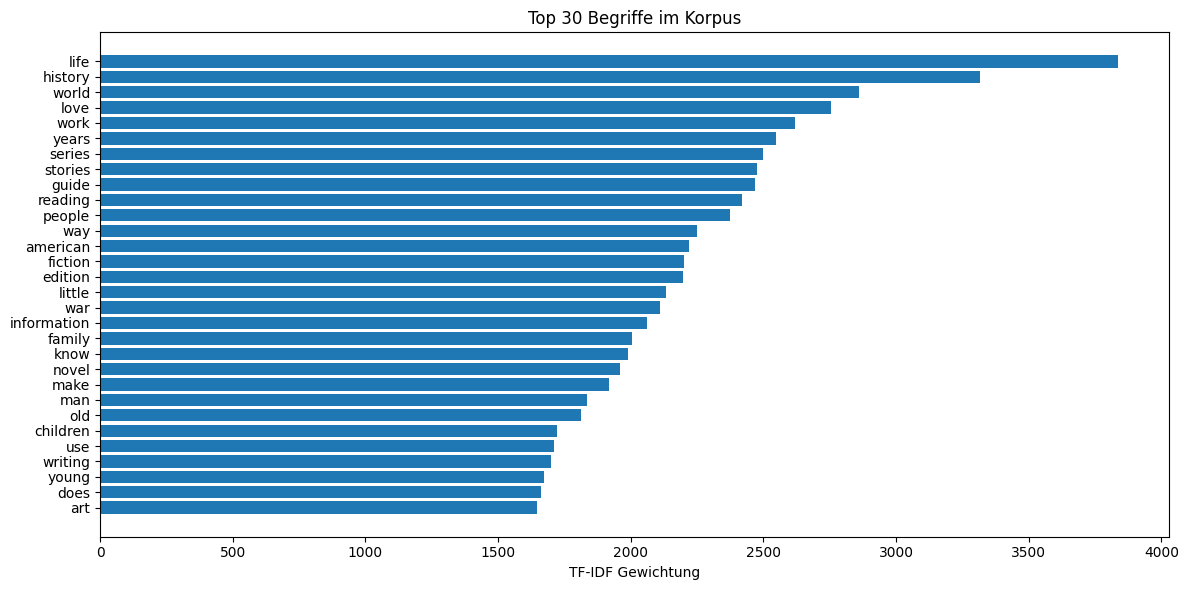

In [9]:
# TF-IDF mit Parametereinstellung, die im weiteren Verlauf noch getuned werden
tfidf = TfidfVectorizer(
    stop_words=stop_words,
    max_features=5000,
    max_df=0.8,
    min_df=5
)

# Vektorisierung
tfidf_matrix = tfidf.fit_transform(books["combined_features"])

# TF-IDF-Werte summieren
tfidf_sum = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
feature_names = tfidf.get_feature_names_out()

# Top-N Begriffe extrahieren
top_n = 30
top_indices = np.argsort(tfidf_sum)[-top_n:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_values = tfidf_sum[top_indices]

# Visualisierung
plt.figure(figsize=(12, 6))
plt.barh(top_features[::-1], top_values[::-1])
plt.xlabel("TF-IDF Gewichtung")
plt.title("Top 30 Begriffe im Korpus")
plt.tight_layout()
plt.show()


## 🎯 Empfehlungsfunktion

In [13]:
def get_recommendations(title, tfidf_vectorizer, tfidf_matrix, books_df, top_n=10):
    """
    Speicherfreundlich: vergleicht nur den gewählten Titel on-the-fly.
    """
    if title not in books_df["Title"].values:
        return ["❌ Titel nicht gefunden"]

    # Index des Titels finden
    idx = books_df.index[books_df["Title"] == title].tolist()[0]

    # Vektor des Titels extrahieren
    title_vec = tfidf_matrix[idx]

    # Cosine Similarity nur gegen diesen Vektor berechnen
    sim_scores = cosine_similarity(title_vec, tfidf_matrix).flatten()

    # Top-N Empfehlungen (ohne sich selbst)
    top_indices = sim_scores.argsort()[::-1][1:top_n+1]

    return books_df["Title"].iloc[top_indices].tolist()


## 🔧 Hyperparameter-Tuning mit Grid Search

Um die Qualität des Empfehlungssystems zu verbessern, wird ein systematisches Tuning der wichtigsten TF-IDF-Hyperparameter durchgeführt. 
Ziel ist es, sinnvolle Kombinationen hinsichtlich Ähnlichkeitspräzision und Ergebnisdiversität zu vergleichen.

### ⚙️ Erläuterung der Hyperparameter

Im Rahmen des Grid Search wurden folgende Hyperparameter des `TfidfVectorizer` variiert:

- **`max_df`**: Gibt an, bei welchem Anteil an Dokumenten ein Begriff als zu häufig angesehen wird und daher ignoriert wird. Beispiel: `max_df=0.8` bedeutet, Begriffe, die in mehr als 80 % aller Dokumente vorkommen, werden ausgeschlossen (z. B. generische Wörter wie „chapter“, „page“ etc.).

- **`min_df`**: Gibt die minimale Dokumenthäufigkeit an, ab der ein Begriff in das Vokabular aufgenommen wird. Beispiel: `min_df=2` schließt Begriffe aus, die nur in einem einzigen Buch vorkommen.

- **`ngram_range`**: Definiert, ob nur einzelne Wörter (`(1, 1)`) oder auch Wortkombinationen wie Bigrams (`(1, 2)`) berücksichtigt werden. Bigrams können spezifischere Bedeutungen erfassen, z. B. „climate change“.

- **`sublinear_tf`**: Wenn auf `True` gesetzt, wird die Termfrequenz logarithmisch skaliert (`1 + log(tf)` statt `tf`). Dies reduziert den Einfluss von sehr häufigen Begriffen innerhalb eines Dokuments.

Alle Kombinationen dieser Parameter wurden systematisch getestet, um deren Einfluss auf die Empfehlungsgenauigkeit und die semantische Diversität der Ergebnisse zu evaluieren.



In [11]:

import itertools
from sklearn.metrics.pairwise import cosine_similarity

# Parameterkombinationen (max. 8)
param_grid = {
    'max_df': [0.8, 0.9],
    'min_df': [2],
    'ngram_range': [(1, 1), (1, 2)],
    'sublinear_tf': [True, False]
}

# 5 zufällige Titel
sample_titles = books["Title"].drop_duplicates().sample(5, random_state=42).tolist()
results = []

for i, (max_df, min_df, ngram_range, sublinear_tf) in enumerate(itertools.product(
    param_grid['max_df'],
    param_grid['min_df'],
    param_grid['ngram_range'],
    param_grid['sublinear_tf']
)):
    print(f"🔧 Konfiguration {i+1} wird getestet...")

    tfidf = TfidfVectorizer(
        stop_words=stop_words,
        max_features=5000,
        max_df=max_df,
        min_df=min_df,
        ngram_range=ngram_range,
        sublinear_tf=sublinear_tf
    )
    matrix = tfidf.fit_transform(books["combined_features"])
    total_sim = 0
    total_div = 0
    valid_titles = 0

    for title in sample_titles:
        idx = books.index[books["Title"] == title].tolist()
        if not idx:
            continue
        idx = idx[0]
        vec = matrix[idx]
        sims = cosine_similarity(vec, matrix).flatten()
        top_indices = sims.argsort()[::-1][1:11]  # Top 10 außer sich selbst

        top_sims = sims[top_indices]
        avg_sim = top_sims.mean()

        top_vecs = matrix[top_indices]
        diversity = 1 - cosine_similarity(top_vecs).mean()

        total_sim += avg_sim
        total_div += diversity
        valid_titles += 1

    if valid_titles > 0:
        results.append({
            "Config_ID": f"C{i+1}",
            "max_df": max_df,
            "min_df": min_df,
            "ngram_range": ngram_range,
            "sublinear_tf": sublinear_tf,
            "mean_topN_similarity": round(total_sim / valid_titles, 4),
            "mean_topN_diversity": round(total_div / valid_titles, 4)
        })

results_df = pd.DataFrame(results)
results_df.sort_values(by="mean_topN_similarity", ascending=False).reset_index(drop=True)


🔧 Konfiguration 1 wird getestet...
🔧 Konfiguration 2 wird getestet...
🔧 Konfiguration 3 wird getestet...
🔧 Konfiguration 4 wird getestet...
🔧 Konfiguration 5 wird getestet...
🔧 Konfiguration 6 wird getestet...
🔧 Konfiguration 7 wird getestet...
🔧 Konfiguration 8 wird getestet...


,Config_ID,max_df,min_df,ngram_range,sublinear_tf,mean_topN_similarity,mean_topN_diversity
0,C4,0.8,2,"(1, 2)",False,0.3136,0.5930
1,C8,0.9,2,"(1, 2)",False,0.3136,0.5930
2,C2,0.8,2,"(1, 1)",False,0.3102,0.5909
3,C6,0.9,2,"(1, 1)",False,0.3102,0.5909
4,C3,0.8,2,"(1, 2)",True,0.2205,0.7409
5,C7,0.9,2,"(1, 2)",True,0.2205,0.7409
6,C1,0.8,2,"(1, 1)",True,0.2174,0.7474
7,C5,0.9,2,"(1, 1)",True,0.2174,0.7474


## 📊 Interpretation der Grid-Search-Ergebnisse

Das durchgeführte Hyperparameter-Tuning mittels Grid Search verglich 8 Konfigurationen des `TfidfVectorizer` anhand zweier Metriken. Dabei wurde über 5 zufällig gewählte Bücher gemittelt.

- **mean_topN_similarity**: Durchschnittliche Ähnlichkeit der Top-10-Empfehlungen zum ursprünglichen Titel  
- **mean_topN_diversity**: Durchschnittliche inhaltliche Streuung (1 - Ähnlichkeit) innerhalb der Top-10-Empfehlungen

### 🔎 Beobachtungen:

- **Die höchste durchschnittliche Ähnlichkeit** (0.3136) erzielten die Konfigurationen `C4` und `C8`, jeweils mit:
  - `min_df = 2`
  - `ngram_range = (1, 2)`
  - `sublinear_tf = False`
  - `max_df = 0.8` bzw. `0.9`
  
- Diese Konfigurationen hatten entsprechend eine **relativ geringe Diversität** (~0.5930), was auf sehr fokussierte, teils redundante Empfehlungen hindeutet.

- **Die Konfigurationen mit `sublinear_tf = True`** (C1, C3, C5, C7) erzeugten eine signifikant höhere Diversität (~0.74), allerdings auf Kosten der Ähnlichkeit (nur ~0.22–0.23).  
  Das spricht für breitere, aber potenziell weniger passgenaue Empfehlungen.

### ✅ Empfehlung:

Je nach Zielsetzung lässt sich aus den Ergebnissen folgender Trade-off ableiten:

- Für **präzise Empfehlungen mit engem thematischem Fokus** empfiehlt sich eine Konfiguration wie **C4**  
- Für **diversere, explorativere Vorschläge** (z. B. in Discover- oder Explore-Modi) eignen sich Konfigurationen wie **C3** oder **C7**

Ein dynamisches Umschalten je nach Nutzerbedürfnis (z. B. Exploration vs. Präzision) wäre denkbar.

In [15]:
## 🎯 Zufälliger Testlauf: Empfehlungsbeispiel

# Zufälligen Buchtitel aus dem Datensatz ziehen
random_title = books["Title"].drop_duplicates().sample(1, random_state=42).iloc[0]
print(f"📘 Zufällig ausgewählter Titel:\n→ {random_title}")

# Empfehlungsfunktion aufrufen
recommendations = get_recommendations(random_title, tfidf, tfidf_matrix, books, top_n=10)
print("\n🔁 Top-10 Empfehlungen:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")


📘 Zufällig ausgewählter Titel:
→ The Naked Corporation: How the Age of Transparency Will Revolutionize Business

🔁 Top-10 Empfehlungen:
1. Inc. yourself;: How to profit by setting up your own corporation
2. How to Start Your Own 'S' Corporation
3. Incorporate & Grow Rich!
4. The Clickable Corporation: Successful Strategies for Capturing the Internet Advantage
5. Naked Skydiving
6. Inc. yourself: How to profit by setting up your own corporation
7. Colossus: How the Corporation Changed America
8. Corporation Law
9. Naked in the Boardroom: A CEO Bares Her Secrets So You Can Transform Your Career
10. Corporation man
